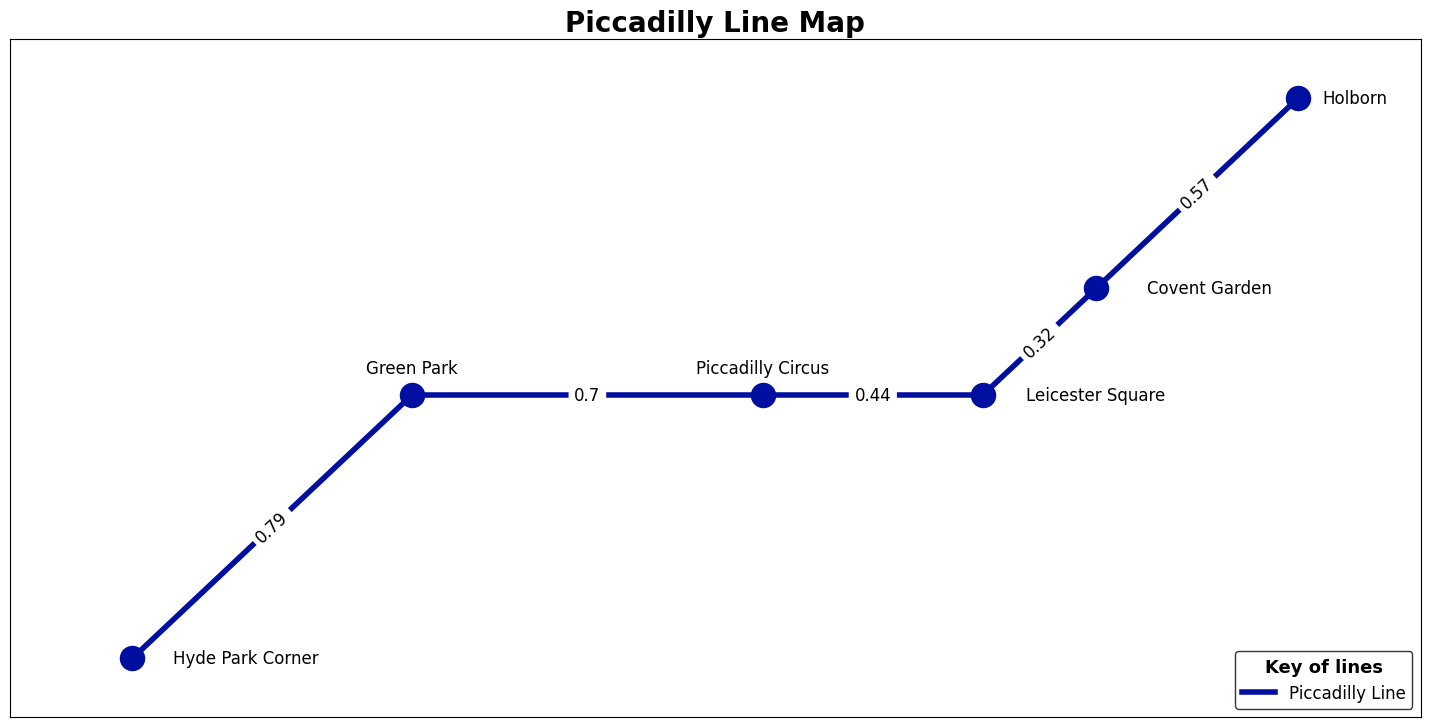

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# ------------------- Data Loading -------------------
# Load the CSV file
file_path = '../csv/station_coordinates.csv'
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()

# Load the line color data
color_file_path = '../csv/line_colors.csv'
color_data = pd.read_csv(color_file_path)
color_data.columns = color_data.columns.str.strip()

# ------------------- Corlor Convert Function -------------------
# Convert RGB to HEX in the color mapping
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'

color_data['HexColor'] = color_data.apply(
    lambda row: rgb_to_hex(row['ColorR'], row['ColorG'], row['ColorB']), axis=1
)

# Create a dictionary for line colors
color_mapping = dict(zip(color_data['Line'], color_data['HexColor']))

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Station Data -------------------
# Define Piccadilly Line edges
piccadilly_line_edges = [
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
]

# Calculate distances using haversine formula
distances = {}
for station1, station2 in piccadilly_line_edges:
    station1_data = stations_data[stations_data["Station"] == station1].iloc[0]
    station2_data = stations_data[stations_data["Station"] == station2].iloc[0]
    distance = haversine(
        station1_data["Latitude"],
        station1_data["Longitude"],
        station2_data["Latitude"],
        station2_data["Longitude"],
    )
    distances[(station1, station2)] = round(distance, 2)

# Cumulative distances for proportional placement
cumulative_distances = [0]  # Start from 0 km
for edge in distances:
    cumulative_distances.append(cumulative_distances[-1] + distances[edge])

# Normalize distances to fit within a 1-unit range
max_distance = cumulative_distances[-1]
normalized_distances = [d / max_distance for d in cumulative_distances]

# Adjust x and y coordinates for proportional movement
stations = {}
current_x, current_y = 0.0, 0.0  # Start at origin
stations["Hyde Park Corner"] = (current_x, current_y)  # First station

# Define movement type for each segment
movements = [
    "diagonal_up",  # Hyde Park Corner -> Green Park
    "sideways",     # Green Park -> Piccadilly Circus
    "sideways",     # Piccadilly Circus -> Leicester Square
    "diagonal_up",  # Leicester Square -> Covent Garden
    "diagonal_up",  # Covent Garden -> Holborn
]

# Define step-wise station positions
for i, movement in enumerate(movements):
    distance_ratio = normalized_distances[i + 1] - normalized_distances[i]
    if movement == "sideways":
        current_x += distance_ratio
    elif movement == "diagonal_up":
        step = distance_ratio / np.sqrt(2)
        current_x += step
        current_y += step
    stations[piccadilly_line_edges[i][1]] = (current_x, current_y)

# ------------------- Graph Data Preparation -------------------
G = nx.Graph()

# Add nodes with positions
for station, pos in stations.items():
    G.add_node(station, pos=pos)

# Add edges with weights (distances)
for (station1, station2), distance in distances.items():
    G.add_edge(station1, station2, weight=distance, color=color_mapping['Piccadilly'])

positions = nx.get_node_attributes(G, 'pos')
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}
edge_colors = [G[u][v]['color'] for u, v in G.edges()]

# ------------------- Visualization -------------------
plt.figure(figsize=(18.2, 8.8))

# Draw edges with colors
nx.draw_networkx_edges(
    G,
    pos=positions,
    edge_color=edge_colors,
    width=4
)

# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos=positions,
    node_size=300,
    node_color=color_mapping['Piccadilly']
)

# Draw labels for stations with adjusted positions
label_pos_adjustments = {
    "Covent Garden": (positions["Covent Garden"][0] + 0.08, positions["Covent Garden"][1]),
    "Green Park": (positions["Green Park"][0], positions["Green Park"][1] + 0.02),
    "Holborn": (positions["Holborn"][0] + 0.04, positions["Holborn"][1]),
    "Hyde Park Corner": (positions["Hyde Park Corner"][0] + 0.08, positions["Hyde Park Corner"][1]),
    "Leicester Square": (positions["Leicester Square"][0] + 0.08, positions["Leicester Square"][1]),
    "Piccadilly Circus": (positions["Piccadilly Circus"][0], positions["Piccadilly Circus"][1] + 0.02),
}
nx.draw_networkx_labels(
    G,
    pos=label_pos_adjustments,
    font_size=12,
    font_weight='normal'
)

# Draw labels for edges (distances in km)
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_labels,
    font_size=12,
    font_weight='normal'
)


legend_elements = [
    plt.Line2D([0], [0], color=color_mapping['Piccadilly'], lw=4, label='Piccadilly Line')
]
legend = plt.legend(
    handles=legend_elements,
    loc='lower right',
    fontsize=12,
    frameon=True,
    ncol=1,
    title="Key of lines"
)
legend.get_frame().set_edgecolor('#000000')
legend.get_frame().set_linewidth(1)
legend.get_title().set_fontsize('13')
legend.get_title().set_fontweight('bold')

# Add the main title for the visualization
plt.title("Piccadilly Line Map", fontsize=20, fontweight='bold')

# Show the plot
plt.show()